In [1]:
from collections import OrderedDict
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
from urbansim_templates.models import SmallMultinomialLogitStep
import orca
import os; os.chdir('../')
import warnings; warnings.simplefilter('ignore')

import pandas as pd
# import pandana as pdna
import time
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import reduce

# import matplotlib
# matplotlib.style.use('ggplot')

%matplotlib inline

pd.options.display.max_columns = 80

/home/emma/anaconda/envs/ual-model/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import seaborn as sns
%matplotlib notebook

import glob

from scripts import datasources, models, variables

mm.initialize()

Loading model step 'TOD_choice'
Loading model step 'WLCM'


In [3]:
trips = pd.read_csv('/home/emma/ual_model_workspace/fall-2018-models/notebooks-emma/HWtrips_101418.csv')

trips.head()

,Unnamed: 0,HHPER,HHPERTRIP,origin,origin_dwell,origin_ST,origin_ET,trip_ET,TT,Ozone,Dzone,Oxcord,Oycord,Dxcord,Dycord,MODE
0,0,10352742,1.035274e+09,home,13.583333,19.166667,8.75,9.166667,0.416667,424.0,700.0,-122.017274,37.388281,-121.664242,37.151629,drive_alone
1,1,10352742,1.035274e+09,work,7.583333,9.166667,16.75,19.166667,2.416667,700.0,424.0,-121.664242,37.151629,-122.017274,37.388281,drive_alone
2,2,10414944,1.041494e+09,home,14.500000,18.000000,8.50,8.750000,0.250000,1095.0,1152.0,-122.091521,38.010760,-122.118103,37.885783,drive_alone
3,3,10414944,1.041494e+09,work,8.750000,8.750000,17.50,18.000000,0.500000,1152.0,1095.0,-122.118103,37.885783,-122.091521,38.010760,drive_alone
4,4,10417661,1.041766e+09,home,13.250000,18.750000,8.00,9.000000,1.000000,241.0,69.0,-122.414811,37.610585,-122.447100,37.779020,drive_alone


In [4]:
TOD_list = ['EA','AM','MD','PM','EV']
trips['TOD'] = (
    ((trips.origin_ET.between(3,6,inclusive = False)) | (trips.origin_ET==3))*1 +
    ((trips.origin_ET.between(6,9,inclusive = False)) | (trips.origin_ET==6))*2 +
    ((trips.origin_ET.between(9,15.5,inclusive = False)) | (trips.origin_ET==9))*3 +
    ((trips.origin_ET.between(15.5,18.5,inclusive = False)) | (trips.origin_ET==15.5))*4 +
    ((trips.origin_ET>=18.5))*5 +
    ((trips.origin_ET.between(0,3,inclusive = False)) | (trips.origin_ET==0))*5
)
TOD_dict = dict(zip(range(1,6),TOD_list))
trips['TOD'] = trips['TOD'].replace(TOD_dict)

TOD_dict = dict(zip(['EA', 'AM', 'MD', 'PM', 'EV'],range(1,6)))
trips['TOD'] = trips['TOD'].replace(TOD_dict)

trips['TOD'] = trips['TOD'] - 1

## Prepare table for model selecting HW and WH departure times at once

In [5]:
#select people who make both home-work and work-home trips:
tripsII = trips.groupby('HHPER').filter(lambda x: len(x) == 2)

In [6]:
#make sure all home-work trip rows are listed first
tripsIII = tripsII.sort_values(['HHPER','origin']).reset_index()

In [7]:
#move work-home trip info up into home-work trip rows

tripsIII['work_dwell'] = tripsIII.groupby('HHPER', group_keys=False).origin_dwell.shift(-1)
tripsIII['work_ST'] = tripsIII.groupby('HHPER', group_keys=False).origin_ST.shift(-1)
tripsIII['WH_trip_ST'] = tripsIII.groupby('HHPER', group_keys=False).origin_ET.shift(-1)
tripsIII['WH_trip_ET'] = tripsIII.groupby('HHPER', group_keys=False).trip_ET.shift(-1)
tripsIII['WH_TT'] = tripsIII.groupby('HHPER', group_keys=False).TT.shift(-1)
tripsIII['WH_mode'] = tripsIII.groupby('HHPER', group_keys=False).MODE.shift(-1)
tripsIII['WH_TOD'] = tripsIII.groupby('HHPER', group_keys=False).TOD.shift(-1)

In [8]:
tripsIII = tripsIII.groupby('HHPER').first().reset_index()

In [9]:
tripsIII.rename(columns = {'origin_dwell':'home_dwell','origin_ST':'home_ST','origin_ET':'HW_trip_ST',
                           'trip_ET':'HW_trip_ET','TT':'HW_TT','MODE':'HW_mode','TOD':'HW_TOD',
                          'Ozone':'Hzone','Dzone':'Wzone','Oxcord':'Hxcord','Oycord':'Hycord',
                          'Dxcord':'Wxcord','Dycord':'Wycord'},inplace = True)

tripsIII['TOD'] = tripsIII['HW_TOD'].map(str) + tripsIII['WH_TOD'].map(str)

tripsIII.head()

,HHPER,index,Unnamed: 0,HHPERTRIP,origin,home_dwell,home_ST,HW_trip_ST,HW_trip_ET,HW_TT,Hzone,Wzone,Hxcord,Hycord,Wxcord,Wycord,HW_mode,HW_TOD,work_dwell,work_ST,WH_trip_ST,WH_trip_ET,WH_TT,WH_mode,WH_TOD,TOD
0,10352742,0,0,1.035274e+09,home,13.583333,19.166667,8.750000,9.166667,0.416667,424.0,700.0,-122.017274,37.388281,-121.664242,37.151629,drive_alone,1,7.583333,9.166667,16.75,19.166667,2.416667,drive_alone,3.0,13.0
1,10414944,2,2,1.041494e+09,home,14.500000,18.000000,8.500000,8.750000,0.250000,1095.0,1152.0,-122.091521,38.010760,-122.118103,37.885783,drive_alone,1,8.750000,8.750000,17.50,18.000000,0.500000,drive_alone,3.0,13.0
2,10417661,4,4,1.041766e+09,home,13.250000,18.750000,8.000000,9.000000,1.000000,241.0,69.0,-122.414811,37.610585,-122.447100,37.779020,drive_alone,1,8.500000,9.000000,17.50,18.750000,1.250000,drive_alone,3.0,13.0
3,10417662,6,6,1.041766e+09,home,13.000000,19.000000,8.000000,8.500000,0.500000,241.0,282.0,-122.414811,37.610585,-122.328418,37.536798,drive_alone,1,10.000000,8.500000,18.50,19.000000,0.500000,drive_alone,4.0,14.0
4,10436132,8,8,1.043613e+09,home,11.866667,19.400000,7.266667,7.866667,0.600000,1004.0,1127.0,-122.252523,37.851942,-122.069993,37.969472,drive_alone,1,11.133333,7.866667,19.00,19.400000,0.400000,drive_alone,4.0,14.0


In [10]:
tripsIII['TOD'] = pd.to_numeric(tripsIII['TOD'])

## Add the demographic variables

In [11]:
person = pd.read_csv('/home/data/CHTS_csv_format/data/Deliv_PER.csv')

person.head()

,SAMPN,PERNO,RELAT,GEND,AGE,AGEB,HISP,RACE1,RACE2,RACE3,RACE4,O_RACE,NTVTY,CNTRY,LIC,USER,TRANS,TPTYP1,TPTYP2,TPTYP3,TPTYP4,TPTYP5,TPTYP6,TPTYP7,O_TPTYP,CLIP1,CLIP2,CLIP3,COMP,MET,PASSTL,FLEX,EMPLY,WKSTAT,O_WKSTAT,JOBS,WLOC,WNAME,WCITY,WSTAT,...,HVLOG,PTRIPS,TOLLF,TOLLR1,TOLLR2,TOLLR3,TOLLR4,TOLLR5,TOLLR6,TOLLR7,TOLLR8,TOLLR9,TOLLR10,TOLLB1,TOLLB2,TOLLB3,TOLLB4,TOLLB5,TOLLB6,TOLLB7,TOLLB8,TOLLB9,TOLLB10,HOVL,NOGOWHY,NOGOWHY_O,InComplete,Moto_trip,WCTFIP,WTRACT,SCTFIP,STRACT,WPrimaryCity,WSTFIP,W2PrimaryCity,W2STFIP,SPrimaryCity,SSTFIP,PERWGT,EXPPERWGT
0,1031985,1,1,1,74,NaN,2,1.0,NaN,NaN,NaN,NaN,1,NaN,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052086,17.647568
1,1031985,2,2,2,73,NaN,2,1.0,NaN,NaN,NaN,NaN,1,NaN,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052086,17.647568
2,1032036,1,1,1,46,NaN,2,1.0,NaN,NaN,NaN,NaN,1,NaN,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,1.0,NaN,NaN,1.0,1.0,HIDDEN,SAN DIEGO,CA,...,NaN,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,73.0,17032.0,NaN,NaN,SAN DIEGO,6.0,NaN,NaN,NaN,NaN,1.223974,414.701494
3,1032036,2,2,2,47,NaN,2,1.0,97.0,NaN,NaN,MULTI-RACIAL,1,NaN,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.863473,292.558373
4,1032036,3,3,1,15,NaN,2,1.0,97.0,NaN,NaN,MULTI-RACIAL,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,73.0,17030.0,NaN,NaN,NaN,NaN,SAN DIEGO,6.0,0.941412,318.965100


In [12]:
person = person[['SAMPN','PERNO','GEND','AGE','HISP','RACE1','RACE2','RACE3','RACE4','O_RACE','NTVTY','LIC','JOBS','HOURS','EDUCA','WSCHED','DISAB','INDUS','OCCUP']]

In [13]:
person['HHPER'] = person['SAMPN'].map(str) + person['PERNO'].map(str)

person['female'] = person['GEND'] - 1

person['HISP'] = np.where(person['HISP'] == 2, 0, person['HISP'])
person['white'] = np.where((person['RACE1'].isin([1.0]) | person['RACE2'].isin([1.0]) | person['RACE3'].isin([1.0]) | person['RACE4'].isin([1.0])),1,0)
person['black'] = np.where((person['RACE1'].isin([2.0]) | person['RACE2'].isin([2.0]) | person['RACE3'].isin([2.0]) | person['RACE4'].isin([2.0])),1,0)
person['native'] = np.where((person['RACE1'].isin([3.0]) | person['RACE2'].isin([3.0]) | person['RACE3'].isin([3.0]) | person['RACE4'].isin([3.0])),1,0)
person['asian'] = np.where((person['RACE1'].isin([4.0]) | person['RACE2'].isin([4.0]) | person['RACE3'].isin([4.0]) | person['RACE4'].isin([4.0])),1,0)
person['PI'] = np.where((person['RACE1'].isin([5.0]) | person['RACE2'].isin([5.0]) | person['RACE3'].isin([5.0]) | person['RACE4'].isin([5.0])),1,0)

person['immigrant'] = person['NTVTY'] - 1
person['nolic'] = person['LIC'] - 1

person['DISAB'] = np.where(person['DISAB'] == 2, 0, person['HISP'])

person.head()

,SAMPN,PERNO,GEND,AGE,HISP,RACE1,RACE2,RACE3,RACE4,O_RACE,NTVTY,LIC,JOBS,HOURS,EDUCA,WSCHED,DISAB,INDUS,OCCUP,HHPER,female,white,black,native,asian,PI,immigrant,nolic
0,1031985,1,1,74,0,1.0,NaN,NaN,NaN,NaN,1,1.0,NaN,NaN,6,NaN,0,NaN,NaN,10319851,0,1,0,0,0,0,0,0.0
1,1031985,2,2,73,0,1.0,NaN,NaN,NaN,NaN,1,1.0,NaN,NaN,6,NaN,0,NaN,NaN,10319852,1,1,0,0,0,0,0,0.0
2,1032036,1,1,46,0,1.0,NaN,NaN,NaN,NaN,1,1.0,1.0,40.0,6,2.0,0,54.0,15.0,10320361,0,1,0,0,0,0,0,0.0
3,1032036,2,2,47,0,1.0,97.0,NaN,NaN,MULTI-RACIAL,1,1.0,NaN,NaN,6,NaN,0,NaN,NaN,10320362,1,1,0,0,0,0,0,0.0
4,1032036,3,1,15,0,1.0,97.0,NaN,NaN,MULTI-RACIAL,1,NaN,NaN,NaN,1,NaN,0,NaN,NaN,10320363,0,1,0,0,0,0,0,NaN


In [14]:
hh_df = pd.read_csv('/home/data/CHTS_csv_format/data/Deliv_HH.csv')[
  ['SAMPN','HHVEH','HHBIC','OWN','INCOM','HHSIZ']]

hh_df['rent'] = hh_df['OWN'] - 1

hh_df.head()

,SAMPN,HHVEH,HHBIC,OWN,INCOM,HHSIZ,rent
0,1031985,2,2,1,3,2,0
1,1032036,1,4,1,7,5,0
2,1032053,2,2,2,2,6,1
3,1032425,2,3,1,7,2,0
4,1032558,0,0,2,1,1,1


In [15]:
demo = person.merge(hh_df,on = 'SAMPN',how = 'left')

demo.head()

,SAMPN,PERNO,GEND,AGE,HISP,RACE1,RACE2,RACE3,RACE4,O_RACE,NTVTY,LIC,JOBS,HOURS,EDUCA,WSCHED,DISAB,INDUS,OCCUP,HHPER,female,white,black,native,asian,PI,immigrant,nolic,HHVEH,HHBIC,OWN,INCOM,HHSIZ,rent
0,1031985,1,1,74,0,1.0,NaN,NaN,NaN,NaN,1,1.0,NaN,NaN,6,NaN,0,NaN,NaN,10319851,0,1,0,0,0,0,0,0.0,2,2,1,3,2,0
1,1031985,2,2,73,0,1.0,NaN,NaN,NaN,NaN,1,1.0,NaN,NaN,6,NaN,0,NaN,NaN,10319852,1,1,0,0,0,0,0,0.0,2,2,1,3,2,0
2,1032036,1,1,46,0,1.0,NaN,NaN,NaN,NaN,1,1.0,1.0,40.0,6,2.0,0,54.0,15.0,10320361,0,1,0,0,0,0,0,0.0,1,4,1,7,5,0
3,1032036,2,2,47,0,1.0,97.0,NaN,NaN,MULTI-RACIAL,1,1.0,NaN,NaN,6,NaN,0,NaN,NaN,10320362,1,1,0,0,0,0,0,0.0,1,4,1,7,5,0
4,1032036,3,1,15,0,1.0,97.0,NaN,NaN,MULTI-RACIAL,1,NaN,NaN,NaN,1,NaN,0,NaN,NaN,10320363,0,1,0,0,0,0,0,NaN,1,4,1,7,5,0


In [16]:
#drop RACE columns, gend, ntvty, lic, own
demo = demo.drop(columns=['GEND','RACE1','RACE2','RACE3','RACE4','O_RACE','NTVTY','LIC','OWN'])

In [17]:
na_dict = {
    'female':[8],
    'AGE':[998,999],
#     'RACE':[97,98,99],
    'immigrant':[7,8],
    'nolic':[7,8],
    'JOBS':[98,99],
    'HOURS':[998,999],
    'EDUCA':[8,9],
    'WSCHED':[8,9],
    'DISAB':[8,9],
    'HHVEH':[98,99],
    'HHBIC':[98,99],
#     'VEHNEW':[8,9],
    'rent':[6,7,8],
    'INCOM':[98,99],
    'HHSIZ':[98,99],
    'INDUS':[98,99],
    'OCCUP':[98,99]
}

for col in na_dict:
    for vals in na_dict[col]:
        demo[col] = demo[col].replace(vals,np.nan)
        
# demo.dropna(inplace = True)

In [18]:
demo.isnull().sum(axis = 0)

SAMPN            0
PERNO            0
AGE           3924
HISP             0
JOBS         57427
HOURS        59603
EDUCA         2088
WSCHED       58106
DISAB          141
INDUS        58467
OCCUP        58897
HHPER            0
female         311
white            0
black            0
native           0
asian            0
PI               0
immigrant      325
nolic        19666
HHVEH            0
HHBIC          148
INCOM         8839
HHSIZ            0
rent           339
dtype: int64

In [19]:
demo1 = demo.copy()

demo1.dropna(inplace = True)

In [20]:
print (len(person.index))
print (len(hh_df.index))
print (len(demo.index))
print (len(demo1.index))

109113
42431
109113
42881


In [21]:
tripsIII['HHPER'] = tripsIII['HHPER'].map(str)

trips0 = pd.merge(tripsIII, demo, on='HHPER')

trips1 = pd.merge(tripsIII, demo1, on='HHPER')

print (len(tripsIII.index))
print (len(trips0.index))
print (len(trips1.index))

5733
5733
4836


In [22]:
tripsIII.isnull().sum(axis = 0)

HHPER          0
index          0
Unnamed: 0     0
HHPERTRIP      0
origin         0
home_dwell     0
home_ST        0
HW_trip_ST     0
HW_trip_ET     0
HW_TT          0
Hzone          0
Wzone          0
Hxcord         0
Hycord         0
Wxcord         0
Wycord         0
HW_mode        0
HW_TOD         0
work_dwell     0
work_ST        0
WH_trip_ST     0
WH_trip_ET    59
WH_TT         59
WH_mode        0
WH_TOD         0
TOD            0
dtype: int64

In [23]:
trips0.isnull().sum(axis = 0)

HHPER           0
index           0
Unnamed: 0      0
HHPERTRIP       0
origin          0
home_dwell      0
home_ST         0
HW_trip_ST      0
HW_trip_ET      0
HW_TT           0
Hzone           0
Wzone           0
Hxcord          0
Hycord          0
Wxcord          0
Wycord          0
HW_mode         0
HW_TOD          0
work_dwell      0
work_ST         0
WH_trip_ST      0
WH_trip_ET     59
WH_TT          59
WH_mode         0
WH_TOD          0
TOD             0
SAMPN           0
PERNO           0
AGE           245
HISP            0
JOBS           12
HOURS         136
EDUCA          77
WSCHED         58
DISAB           3
INDUS         127
OCCUP         150
female         16
white           0
black           0
native          0
asian           0
PI              0
immigrant      12
nolic           2
HHVEH           0
HHBIC           4
INCOM         468
HHSIZ           0
rent            9
dtype: int64

In [24]:
x = trips0.loc[(trips0['INDUS'].isnull()) & (trips0['OCCUP'].isnull())]

len(x.index)

93

In [25]:
trips = trips1

In [26]:
trips1['less10k'] = np.where(trips1['INCOM'].isin([1.0]),1,0)
trips1['10kless25k'] = np.where(trips1['INCOM'].isin([2.0]),1,0)
trips1['25kless35k'] = np.where(trips1['INCOM'].isin([3.0]),1,0)
trips1['35kless50k'] = np.where(trips1['INCOM'].isin([4.0]),1,0)
trips1['50kless75k'] = np.where(trips1['INCOM'].isin([5.0]),1,0)
trips1['75kless100k'] = np.where(trips1['INCOM'].isin([6.0]),1,0)
trips1['100kless150k'] = np.where(trips1['INCOM'].isin([7.0]),1,0)
trips1['150kless200k'] = np.where(trips1['INCOM'].isin([8.0]),1,0)
trips1['200kless250k'] = np.where(trips1['INCOM'].isin([9.0]),1,0)
trips1['250kplus'] = np.where(trips1['INCOM'].isin([10.0]),1,0)
trips1['150kplus'] = np.where(trips1['INCOM'].isin([8.0,9.0,10.0]),1,0)

In [27]:
trips1['lessGED'] = np.where(trips1['EDUCA'].isin([1.0]),1,0)
trips1['GED'] = np.where(trips1['EDUCA'].isin([2.0]),1,0)
trips1['someBach'] = np.where(trips1['EDUCA'].isin([3.0]),1,0)
trips1['Assoc'] = np.where(trips1['EDUCA'].isin([4.0]),1,0)
trips1['Bach'] = np.where(trips1['EDUCA'].isin([5.0]),1,0)
trips1['Grad'] = np.where(trips1['EDUCA'].isin([6.0]),1,0)

In [28]:
trips1['minority'] = np.where(trips1['white'] == 1, 0, 1)

trips1.rename(columns = {'WSCHED':'flexsched'},inplace = True)

In [29]:
# trips1[['AGE', 'JOBS', 'HOURS', 'HHVEH', 'HHBIC', 'HHSIZ']].describe()

In [30]:
trips1['16less25'] = np.where(((trips1.AGE.between(16,25,inclusive = False)) | (trips1.AGE==16)),1,0)
trips1['25less40'] = np.where(((trips1.AGE.between(25,40,inclusive = False)) | (trips1.AGE==25)),1,0)
trips1['40less50'] = np.where(((trips1.AGE.between(40,50,inclusive = False)) | (trips1.AGE==40)),1,0)
trips1['50less60'] = np.where(((trips1.AGE.between(50,60,inclusive = False)) | (trips1.AGE==50)),1,0)
trips1['60less85'] = np.where(((trips1.AGE.between(60,85,inclusive = False)) | (trips1.AGE==60)),1,0)

In [31]:
trips1['1job'] = np.where(trips1.JOBS.isin([1.0]),1,0)
trips1['2plusjobs'] = np.where(trips1.JOBS.between(2,5,inclusive = True),1,0)

trips1['35hoursorless'] = np.where(trips1.HOURS.between(1,35,inclusive = True),1,0)
trips1['35to45hours'] = np.where(((trips1.HOURS.between(35,45,inclusive = False)) | (trips1.HOURS==45)),1,0)
trips1['over45hours'] = np.where(((trips1.HOURS.between(45,90,inclusive = False)) | (trips1.HOURS==90)),1,0)

In [32]:
trips1['noveh'] = np.where(trips1.HHVEH.isin([0.0]),1,0)
trips1['1veh'] = np.where(trips1.HHVEH.isin([1.0]),1,0)
trips1['2veh'] = np.where(trips1.HHVEH.isin([2.0]),1,0)
trips1['3plusveh'] = np.where(trips1.HHVEH.between(3,8,inclusive = True),1,0)

trips1['nobic'] = np.where(trips1.HHBIC.isin([0.0]),1,0)
# trips1['1'] = np.where(trips1.HHVEH.isin([1.0]),1,0)
# trips1['2veh'] = np.where(trips1.HHVEH.isin([2.0]),1,0)
# trips1['3plusveh'] = np.where(trips1.HHVEH.between(3,8,inclusive = True),1,0)

trips1['1per'] = np.where(trips1.HHSIZ.isin([1.0]),1,0)
trips1['2per'] = np.where(trips1.HHSIZ.isin([2.0]),1,0)
trips1['3per'] = np.where(trips1.HHSIZ.isin([3.0]),1,0)
trips1['4plusper'] = np.where(trips1.HHSIZ.between(4,8,inclusive = True),1,0)

In [33]:
### make indus and occup dummies ###

trips1 = trips

trips['manager'] = np.where(trips['OCCUP'].isin([11]),1,0)
trips['business_finance'] = np.where(trips['OCCUP'].isin([13]),1,0)
trips['computer_math'] = np.where(trips['OCCUP'].isin([15]),1,0)
trips['arch_eng'] = np.where(trips['OCCUP'].isin([17]),1,0)
trips['scientist'] = np.where(trips['OCCUP'].isin([19]),1,0)
trips['socialservice'] = np.where(trips['OCCUP'].isin([21]),1,0)
trips['legal'] = np.where(trips['OCCUP'].isin([23]),1,0)
trips['teacher'] = np.where(trips['OCCUP'].isin([25]),1,0)
trips['arts_entertain'] = np.where(trips['OCCUP'].isin([27]),1,0)
trips['healthcare_practitioner'] = np.where(trips['OCCUP'].isin([29]),1,0)
trips['healthcare_support'] = np.where(trips['OCCUP'].isin([31]),1,0)
trips['protectiveservice'] = np.where(trips['OCCUP'].isin([33]),1,0)
trips['foodprep'] = np.where(trips['OCCUP'].isin([35]),1,0)
trips['cleaning_maintenance'] = np.where(trips['OCCUP'].isin([37]),1,0)
trips['personalcare'] = np.where(trips['OCCUP'].isin([39]),1,0)
trips['sales'] = np.where(trips['OCCUP'].isin([41]),1,0)
trips['office_admin'] = np.where(trips['OCCUP'].isin([43]),1,0)
trips['farmer'] = np.where(trips['OCCUP'].isin([45]),1,0)
trips['construction_extraction'] = np.where(trips['OCCUP'].isin([47]),1,0)
trips['installation_mechanic'] = np.where(trips['OCCUP'].isin([49]),1,0)
trips['production'] = np.where(trips['OCCUP'].isin([51]),1,0)
trips['transporter'] = np.where(trips['OCCUP'].isin([53]),1,0)
trips['military'] = np.where(trips['OCCUP'].isin([55]),1,0)
trips['other'] = np.where(trips['OCCUP'].isin([97]),1,0)

trips['agri'] = np.where(trips['INDUS'].isin([11]),1,0)
trips['mining'] = np.where(trips['INDUS'].isin([21]),1,0)
trips['utility'] = np.where(trips['INDUS'].isin([22]),1,0)
trips['construction'] = np.where(trips['INDUS'].isin([23]),1,0)
trips['manufacturing'] = np.where(trips['INDUS'].isin([31]),1,0)
trips['sector_retail'] = np.where(trips['INDUS'].isin([44,45]),1,0)
trips['sector_whlsale'] = np.where(trips['INDUS'].isin([42]),1,0)
trips['transport'] = np.where(trips['INDUS'].isin([48]),1,0)
trips['info'] = np.where(trips['INDUS'].isin([51]),1,0)
trips['finance'] = np.where(trips['INDUS'].isin([52]),1,0)
trips['realestate'] = np.where(trips['INDUS'].isin([53]),1,0)
trips['scitech'] = np.where(trips['INDUS'].isin([54]),1,0)
trips['manage'] = np.where(trips['INDUS'].isin([55]),1,0)
trips['admin'] = np.where(trips['INDUS'].isin([56]),1,0)
trips['educ'] = np.where(trips['INDUS'].isin([61]),1,0)
trips['health'] = np.where(trips['INDUS'].isin([62]),1,0)
trips['artsrec'] = np.where(trips['INDUS'].isin([71]),1,0)
trips['hospitality'] = np.where(trips['INDUS'].isin([72]),1,0)
trips['services'] = np.where(trips['INDUS'].isin([81]),1,0)
trips['gov'] = np.where(trips['INDUS'].isin([92]),1,0)
trips['other'] = np.where(trips['INDUS'].isin([97]),1,0)

# alts['sector_retail'] = alts['sector_id'].isin([44, 45]).astype(int)
# alts['sector_healthcare'] = alts['sector_id'].isin([62]).astype(int)
# alts['sector_tech'] = alts['sector_id'].isin([51, 54]).astype(int)
# alts['sector_food_and_hosp'] = alts['sector_id'].isin([72]).astype(int)
# alts['sector_mfg'] = alts['sector_id'].isin([31, 32, 33]).astype(int)
# alts['sector_edu_serv'] = alts['sector_id'].isin([61]).astype(int)
# alts['sector_oth_serv'] = alts['sector_id'].isin([81]).astype(int)
# alts['sector_constr'] = alts['sector_id'].isin([23]).astype(int)
# alts['sector_gov'] = alts['sector_id'].isin([92]).astype(int)
# alts['sector_fire'] = alts['sector_id'].isin([52, 53]).astype(int)
# alts['sector_whlsale'] = alts['sector_id'].isin([42]).astype(int)
# alts['sector_admin'] = alts['sector_id'].isin([56]).astype(int)
# alts['sector_transport'] = alts['sector_id'].isin([48]).astype(int)
# alts['sector_arts'] = alts['sector_id'].isin([71]).astype(int)
# alts['sector_util'] = alts['sector_id'].isin([22]).astype(int)

trips1 = trips

## Creating the skims table

### still haven't added walk and bike distances and times (might differ by direction even if not by time)

In [34]:
# skim_dir = '/home/data/fall_2018/mtc_skims'
# distance_EA = pd.read_csv(skim_dir + f'/DistanceSkimsDatabaseEA.csv').replace(-999, 9999)
# distance_AM = pd.read_csv(skim_dir + f'/DistanceSkimsDatabaseAM.csv').replace(-999, 9999)
# distance_MD = pd.read_csv(skim_dir + f'/DistanceSkimsDatabaseMD.csv').replace(-999, 9999)
# distance_PM = pd.read_csv(skim_dir + f'/DistanceSkimsDatabasePM.csv').replace(-999, 9999)
# distance_EV = pd.read_csv(skim_dir + f'/DistanceSkimsDatabaseEV.csv').replace(-999, 9999)

# cost_EA = pd.read_csv(skim_dir + f'/CostSkimsDatabaseEA.csv').replace(-999, 9999)
# cost_AM = pd.read_csv(skim_dir + f'/CostSkimsDatabaseAM.csv').replace(-999, 9999)
# cost_MD = pd.read_csv(skim_dir + f'/CostSkimsDatabaseMD.csv').replace(-999, 9999)
# cost_PM = pd.read_csv(skim_dir + f'/CostSkimsDatabasePM.csv').replace(-999, 9999)
# cost_EV = pd.read_csv(skim_dir + f'/CostSkimsDatabaseEV.csv').replace(-999, 9999)

# Time_EA = pd.read_csv(skim_dir + f'/TimeSkimsDatabaseEA.csv').replace(-999, 9999)
# Time_AM = pd.read_csv(skim_dir + f'/TimeSkimsDatabaseAM.csv').replace(-999, 9999)
# Time_MD = pd.read_csv(skim_dir + f'/TimeSkimsDatabaseMD.csv').replace(-999, 9999)
# Time_PM = pd.read_csv(skim_dir + f'/TimeSkimsDatabasePM.csv').replace(-999, 9999)
# Time_EV = pd.read_csv(skim_dir + f'/TimeSkimsDatabaseEV.csv').replace(-999, 9999)

In [35]:
# distance_EA = distance_EA.rename(
#         columns = dict(zip([i for i in distance_EA.columns if i not in ['orig','dest']],
#          [i+ f'_distance_EA' for i in distance_EA.columns if i not in ['orig','dest']])))

In [36]:
# distance_AM = distance_AM.rename(
#         columns = dict(zip([i for i in distance_AM.columns if i not in ['orig','dest']],
#          [i+ f'_distance_AM' for i in distance_AM.columns if i not in ['orig','dest']])))

In [37]:
# distance_MD = distance_MD.rename(
#         columns = dict(zip([i for i in distance_MD.columns if i not in ['orig','dest']],
#          [i+ f'_distance_MD' for i in distance_MD.columns if i not in ['orig','dest']])))

In [38]:
# distance_PM = distance_PM.rename(
#         columns = dict(zip([i for i in distance_PM.columns if i not in ['orig','dest']],
#          [i+ f'_distance_PM' for i in distance_PM.columns if i not in ['orig','dest']])))

In [39]:
# distance_EV = distance_EV.rename(
#         columns = dict(zip([i for i in distance_EV.columns if i not in ['orig','dest']],
#          [i+ f'_distance_EV' for i in distance_EV.columns if i not in ['orig','dest']])))

In [40]:
# cost_EA = cost_EA.rename(
#         columns = dict(zip([i for i in cost_EA.columns if i not in ['orig','dest']],
#          [i+ f'_cost_EA' for i in cost_EA.columns if i not in ['orig','dest']])))

In [41]:
# cost_AM=cost_AM.rename(
#         columns = dict(zip([i for i in cost_AM.columns if i not in ['orig','dest']],
#          [i+ f'_cost_AM' for i in cost_AM.columns if i not in ['orig','dest']])))

In [42]:
# cost_MD=cost_MD.rename(
#         columns = dict(zip([i for i in cost_MD.columns if i not in ['orig','dest']],
#          [i+ f'_cost_MD' for i in cost_MD.columns if i not in ['orig','dest']])))

In [43]:
# cost_PM= cost_PM.rename(
#         columns = dict(zip([i for i in cost_PM.columns if i not in ['orig','dest']],
#          [i+ f'_cost_PM' for i in cost_PM.columns if i not in ['orig','dest']])))

In [44]:
# cost_EV=cost_EV.rename(
#         columns = dict(zip([i for i in cost_EV.columns if i not in ['orig','dest']],
#          [i+ f'_cost_EV' for i in cost_EV.columns if i not in ['orig','dest']])))

In [45]:
# Time_EA=Time_EA.rename(
#         columns = dict(zip([i for i in Time_EA.columns if i not in ['orig','dest']],
#          [i+ f'_Time_EA' for i in Time_EA.columns if i not in ['orig','dest']])))

In [46]:
# Time_AM=Time_AM.rename(
#         columns = dict(zip([i for i in Time_AM.columns if i not in ['orig','dest']],
#          [i+ f'_Time_AM' for i in Time_AM.columns if i not in ['orig','dest']])))

In [47]:
# Time_MD=Time_MD.rename(
#         columns = dict(zip([i for i in Time_MD.columns if i not in ['orig','dest']],
#          [i+ f'_Time_MD' for i in Time_MD.columns if i not in ['orig','dest']])))

In [48]:
# Time_PM=Time_PM.rename(
#         columns = dict(zip([i for i in Time_PM.columns if i not in ['orig','dest']],
#          [i+ f'_Time_PM' for i in Time_PM.columns if i not in ['orig','dest']])))

In [49]:
# Time_EV=Time_EV.rename(
#         columns = dict(zip([i for i in Time_EV.columns if i not in ['orig','dest']],
#          [i+ f'_Time_EV' for i in Time_EV.columns if i not in ['orig','dest']])))

In [50]:
# data_frames = [distance_EA,distance_AM,distance_MD,distance_PM,distance_EV,
#               cost_EA,cost_AM,cost_MD,cost_PM,cost_EV,
#               Time_EA,Time_AM,Time_MD,Time_PM,Time_EV]
# skims = reduce(lambda  left,right: pd.merge(left,right,on=['orig','dest'],
#                                             how='outer'), data_frames)

In [51]:
# skims.head()

In [52]:
# skims.to_csv('skims_110118.csv')

In [53]:
# skims = pd.read_csv('/home/emma/ual_model_workspace/fall-2018-models/skims_110118.csv')

In [54]:
# zones = trips1[['HHPER','Hzone','Wzone']]

In [55]:
# skims1 = pd.merge(zones, skims, how = 'left', left_on=['Hzone','Wzone'], right_on=['orig','dest'])

In [56]:
# skims2 = pd.merge(skims1, skims, how = 'left', left_on=['Wzone','Hzone'], right_on=['orig','dest'], suffixes=('_HW', '_WH'))

In [57]:
# skims3 = skims2.copy()
# TOD_list = ['EA','AM','MD','PM','EV']
# var_list = ['distance','cost','Time']
# mode_list_1 = ['da','daToll','s2','s2Toll','s3','s3Toll','walk','bike']
# # mode_list_1 = ['da','daToll','s2','s2Toll']
# mode_list_2 = ['da','daToll','s2','s2Toll','s3','s3Toll','wTrnW']
# # mode_list_2 = ['da','daToll','s2','s2Toll','wTrnW','dTrnW','wTrnD']
# mode_list_3 = ['da','daToll','s2','s2Toll','s3','s3Toll','walk','bike','wTrnW']

# for mode in mode_list_1:
# #     for variable in var_list:

#         for tod1 in TOD_list:
#             for tod2 in TOD_list:
#                 col_name = f'{mode}_distance_{tod1}_{tod2}'
#                 skims3[col_name] = skims3[f'{mode}_distance_{tod1}_HW'] + skims3[f'{mode}_distance_{tod2}_WH']

In [58]:
# for mode in mode_list_2:
# #     for variable in var_list:

#         for tod1 in TOD_list:
#             for tod2 in TOD_list:
#                 col_name = f'{mode}_cost_{tod1}_{tod2}'
#                 skims3[col_name] = skims3[f'{mode}_cost_{tod1}_HW'] + skims3[f'{mode}_cost_{tod2}_WH']

In [59]:
# for mode in mode_list_3:
# #     for variable in var_list:

#         for tod1 in TOD_list:
#             for tod2 in TOD_list:
#                 col_name = f'{mode}_Time_{tod1}_{tod2}'
#                 skims3[col_name] = skims3[f'{mode}_Time_{tod1}_HW'] + skims3[f'{mode}_Time_{tod2}_WH']

In [60]:
# var_list2 = ['cost','Time']
# for variable in var_list2:
#     for tod1 in TOD_list:
#         for tod2 in TOD_list:
#                 col_name = f'dTrnW_{variable}_{tod1}_{tod2}'
#                 skims3[col_name] = skims3[f'dTrnW_{variable}_{tod1}_HW'] + skims3[f'wTrnD_{variable}_{tod2}_WH']

In [61]:
# skims3.drop(skims3.filter(regex='_HW').columns, axis = 1, inplace = True)

# skims3.drop(skims3.filter(regex='_WH').columns, axis = 1, inplace = True)

In [62]:
# skims3.head()

In [63]:
# len(skims3.index)

In [64]:
# skims3.to_csv('/home/emma/ual_model_workspace/fall-2018-models/skims3correct_110518.csv')

In [65]:
skims3 = pd.read_csv('/home/emma/ual_model_workspace/fall-2018-models/skims3correct_110518.csv')

In [66]:
skims3.head()

,Unnamed: 0,HHPER,Hzone,Wzone,da_distance_EA_EA,da_distance_EA_AM,da_distance_EA_MD,da_distance_EA_PM,da_distance_EA_EV,da_distance_AM_EA,da_distance_AM_AM,da_distance_AM_MD,da_distance_AM_PM,da_distance_AM_EV,da_distance_MD_EA,da_distance_MD_AM,da_distance_MD_MD,da_distance_MD_PM,da_distance_MD_EV,da_distance_PM_EA,da_distance_PM_AM,da_distance_PM_MD,da_distance_PM_PM,da_distance_PM_EV,da_distance_EV_EA,da_distance_EV_AM,da_distance_EV_MD,da_distance_EV_PM,da_distance_EV_EV,daToll_distance_EA_EA,daToll_distance_EA_AM,daToll_distance_EA_MD,daToll_distance_EA_PM,daToll_distance_EA_EV,daToll_distance_AM_EA,daToll_distance_AM_AM,daToll_distance_AM_MD,daToll_distance_AM_PM,daToll_distance_AM_EV,daToll_distance_MD_EA,...,dTrnW_cost_MD_EA,dTrnW_cost_MD_AM,dTrnW_cost_MD_MD,dTrnW_cost_MD_PM,dTrnW_cost_MD_EV,dTrnW_cost_PM_EA,dTrnW_cost_PM_AM,dTrnW_cost_PM_MD,dTrnW_cost_PM_PM,dTrnW_cost_PM_EV,dTrnW_cost_EV_EA,dTrnW_cost_EV_AM,dTrnW_cost_EV_MD,dTrnW_cost_EV_PM,dTrnW_cost_EV_EV,dTrnW_Time_EA_EA,dTrnW_Time_EA_AM,dTrnW_Time_EA_MD,dTrnW_Time_EA_PM,dTrnW_Time_EA_EV,dTrnW_Time_AM_EA,dTrnW_Time_AM_AM,dTrnW_Time_AM_MD,dTrnW_Time_AM_PM,dTrnW_Time_AM_EV,dTrnW_Time_MD_EA,dTrnW_Time_MD_AM,dTrnW_Time_MD_MD,dTrnW_Time_MD_PM,dTrnW_Time_MD_EV,dTrnW_Time_PM_EA,dTrnW_Time_PM_AM,dTrnW_Time_PM_MD,dTrnW_Time_PM_PM,dTrnW_Time_PM_EV,dTrnW_Time_EV_EA,dTrnW_Time_EV_AM,dTrnW_Time_EV_MD,dTrnW_Time_EV_PM,dTrnW_Time_EV_EV
0,0,10414944,1095.0,1152.0,27.95,27.95,27.95,27.95,27.95,26.38,26.38,26.38,26.38,26.38,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,27.95,26.38,26.38,26.38,26.38,26.38,27.95,...,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,96.06,94.77,96.24,95.98,98.59,93.18,91.89,93.36,93.10,95.71,96.24,94.95,96.42,96.16,98.77,95.98,94.69,96.16,95.90,98.51,98.59,97.30,98.77,98.51,101.12
1,1,10417661,241.0,69.0,30.92,30.27,30.27,30.27,30.92,30.92,30.27,30.27,30.27,30.92,30.92,30.27,30.27,30.27,30.92,30.92,30.27,30.27,30.27,30.92,30.92,30.27,30.27,30.27,30.92,30.92,30.27,30.27,30.27,30.92,30.92,30.27,30.27,30.27,30.92,30.92,...,880.0,880.0,832.0,880.0,880.0,928.0,928.0,880.0,928.0,928.0,928.0,928.0,880.0,928.0,928.0,134.55,129.62,130.44,128.65,135.75,129.17,124.24,125.06,123.27,130.37,126.83,121.90,122.72,120.93,128.03,125.33,120.40,121.22,119.43,126.53,132.62,127.69,128.51,126.72,133.82
2,2,10417662,241.0,282.0,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,23.86,...,563.0,804.0,804.0,804.0,804.0,563.0,804.0,804.0,804.0,804.0,563.0,804.0,804.0,804.0,804.0,182.87,156.04,155.30,156.01,183.93,155.54,128.71,127.97,128.68,156.60,153.95,127.12,126.38,127.09,155.01,152.77,125.94,125.20,125.91,153.83,178.16,151.33,150.59,151.30,179.22
3,3,10436132,1004.0,1127.0,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,32.33,...,10328.0,739.0,739.0,739.0,10328.0,10328.0,739.0,739.0,739.0,10328.0,19998.0,10409.0,10409.0,10409.0,19998.0,19998.00,10085.15,10089.02,10088.27,19998.00,10087.52,174.67,178.54,177.79,10087.52,10089.01,176.16,180.03,179.28,10089.01,10088.24,175.39,179.26,178.51,10088.24,19998.00,10085.15,10089.02,10088.27,19998.00
4,4,10456071,908.0,116.0,31.94,34.03,31.94,34.03,31.94,33.77,35.86,33.77,35.86,33.77,31.94,34.03,31.94,34.03,31.94,33.77,35.86,33.77,35.86,33.77,31.94,34.03,31.94,34.03,31.94,31.94,34.03,31.94,34.03,31.94,33.77,35.86,33.77,35.86,33.77,31.94,...,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,586.0,104.66,102.11,102.07,102.14,108.25,102.11,99.56,99.52,99.59,105.70,102.07,99.52,99.48,99.55,105.66,102.14,99.59,99.55,99.62,105.73,108.25,105.70,105.66,105.73,111.84


In [67]:
trips1 = trips1.convert_objects(convert_numeric=True)

In [68]:
trips1 = pd.merge(trips1, skims3, how = 'left', on= ['HHPER'])

In [69]:
trips1.TOD.value_counts()

13.0    2346
12.0     573
23.0     420
14.0     404
24.0     377
2.0      201
3.0      196
22.0     164
34.0      73
4.0       23
41.0      18
11.0      15
44.0       9
1.0        6
33.0       4
42.0       3
30.0       1
0.0        1
21.0       1
31.0       1
Name: TOD, dtype: int64

In [111]:
trips1.TOD.value_counts(normalize=True)

13.0    0.485112
12.0    0.118486
23.0    0.086849
14.0    0.083540
24.0    0.077957
2.0     0.041563
3.0     0.040529
22.0    0.033912
34.0    0.015095
4.0     0.004756
41.0    0.003722
11.0    0.003102
44.0    0.001861
1.0     0.001241
33.0    0.000827
42.0    0.000620
30.0    0.000207
0.0     0.000207
21.0    0.000207
31.0    0.000207
Name: TOD, dtype: float64

In [70]:
trips = trips1.loc[trips1['TOD'].isin([2,3,12,13,14,22,23,24])]

In [112]:
trips.TOD.value_counts(normalize=True)

13.0    0.504379
12.0    0.129460
14.0    0.086734
24.0    0.080752
23.0    0.080325
2.0     0.041658
3.0     0.040162
22.0    0.036531
Name: TOD, dtype: float64

In [110]:
# trips.dtypes

In [73]:
# TAZ = pd.read_csv('/home/emma/ual_model_workspace/fall-2018-models/data/MTC_TAZ_accessibility.csv')

In [74]:
# TAZ.head()

In [75]:
# trips.isnull().sum(axis = 0)

In [76]:
# trips = trips.merge(TAZ,left_on = 'Hzone_x',right_on = 'taz1454',how = 'left')

In [77]:
# trips = trips.merge(TAZ,left_on = 'Wzone_x',right_on = 'taz1454',how = 'left', suffixes=('_home', '_work'))

In [78]:
trips = trips.drop(columns=['WH_trip_ET','WH_TT'])
trips.dropna(inplace = True)

In [79]:
# trips.rename(columns = {'bike_15_EA_home':'bike_15_home','bike_30_EA_home':'bike_30_home','bike_45_EA_home':'bike_45_home',
#                        'bike_15_EA_work':'bike_15_work','bike_30_EA_work':'bike_30_work','bike_45_EA_work':'bike_45_work',
#                        'walk_15_EA_home':'walk_15_home','walk_30_EA_home':'walk_30_home','walk_45_EA_home':'walk_45_home',
#                        'walk_15_EA_work':'walk_15_work','walk_30_EA_work':'walk_30_work','walk_45_EA_work':'walk_45_work',},inplace = True)

In [80]:
trips['1plusveh'] = 1 - trips['noveh']
trips['no_higher_ed'] = (trips['EDUCA'] < 5).astype(int)

In [81]:
    # trips['daTime02'] = trips['da_Time_EA_MD']*trips['1plusveh']
    # trips['daTime03'] = trips['da_Time_EA_PM']*trips['1plusveh']
    # trips['daTime12'] = trips['da_Time_AM_MD']*trips['1plusveh']
    # trips['daTime13'] = trips['da_Time_AM_PM']*trips['1plusveh']
    # trips['daTime14'] = trips['da_Time_AM_EV']*trips['1plusveh']
    # trips['daTime22'] = trips['da_Time_MD_MD']*trips['1plusveh']
    # trips['daTime23'] = trips['da_Time_MD_PM']*trips['1plusveh']
    # trips['daTime24'] = trips['da_Time_MD_EV']*trips['1plusveh']

    # trips['wTrnWTime02'] = trips['wTrnW_Time_EA_MD']*trips['noveh']
    # trips['wTrnWTime03'] = trips['wTrnW_Time_EA_PM']*trips['noveh']
    # trips['wTrnWTime12'] = trips['wTrnW_Time_AM_MD']*trips['noveh']
    # trips['wTrnWTime13'] = trips['wTrnW_Time_AM_PM']*trips['noveh']
    # trips['wTrnWTime14'] = trips['wTrnW_Time_AM_EV']*trips['noveh']
    # trips['wTrnWTime22'] = trips['wTrnW_Time_MD_MD']*trips['noveh']
    # trips['wTrnWTime23'] = trips['wTrnW_Time_MD_PM']*trips['noveh']
    # trips['wTrnWTime24'] = trips['wTrnW_Time_MD_EV']*trips['noveh']

In [82]:
# # balanced sampling
# tripsM = pd.concat([trips[trips.TOD == 2].sample(500, random_state = 0, replace=True),
#                     trips[trips.TOD == 3].sample(500, random_state = 0, replace=True),
#                     trips[trips.TOD == 12].sample(500, random_state = 0, replace=True),
#                     trips[trips.TOD == 13].sample(500, random_state = 0, replace=True),
#                     trips[trips.TOD == 14].sample(500, random_state = 0, replace=True),
#                     trips[trips.TOD == 22].sample(500, random_state = 0, replace=True),
#                     trips[trips.TOD == 23].sample(500, random_state = 0, replace=True),
#                     trips[trips.TOD == 24].sample(500, random_state = 0, replace=True),
#                 ])

In [83]:
# tripsM.head()

In [84]:
@orca.table(cache=True)
def tripsA():
    return trips

In [85]:
#add interaction term with household vehicles and drive skims, and no household veh and transit/bike/walk skims,
#also with owning a bike and bike skims
##this suggests transit/bike/walk skims don't matter for people with cars

#need to combine job accessibility measures by sum of morning and afternoon counts

#should I include any skims? they are a feature of mode, which is chosen after the TOD. If no, why does
#SFCTA include accessibility by both car and transit?

#change age, jobs, hours, hhveh, hhbic, and hhsiz to more interpretable categories?

#test origin_dwell, TT?, use just walk distance?

#should any skims data be included here? because time categories are big enough that mode doesn't really influence choice?
#but then why accessibility variables? (total employment within 15 and 30 min by auto and transit for depart and return periods - 
    #and should that be accessibility around home or work?)

m = SmallMultinomialLogitStep()
m.name = 'TOD_choice'
m.tables = ['tripsA']
m.choice_column = 'TOD'
m.model_expression = OrderedDict([
    ('intercept', [2,3,12,13,22,23,24]),
 
# #     ('bike_15_home',[2,22,24]),
#     ('bike_30_home',[23]),
# #     ('bike_45_home',[14]),
# #     ('walk_15_home',[2,3,12,14,22,23,24]),
#     ('walk_30_home',[12]),
# #     ('walk_45_home',[2,24]),
    
# #     ('bike_15_work',[22]),
# #     ('bike_30_work',[22]),
# #     ('bike_45_work',[22]),
# #     ('walk_15_work',[24]),
# #     ('walk_30_work',[14]),
# #     ('walk_45_work',[14]),
    
# # #     ('da_15_EA_home',[2,3]),
# #     ('da_30_EA_home',[2]),
# # #     ('da_45_EA_home',[2,3]),
# #     ('wTrnW_15_EA_home',[3]),
# # #     ('wTrnW_30_EA_home',[2,3]),
# # #     ('wTrnW_45_EA_home',[2,3]),
    
# #     ('da_15_EA_work',[3]),
# # #     ('da_30_EA_work',[2,3]),
# #     ('da_45_EA_work',[3]),
# # #     ('wTrnW_15_EA_work',[2,3]),
# # #     ('wTrnW_30_EA_work',[2,3]),
# # #     ('wTrnW_45_EA_work',[2,3]),
    
# # #     ('da_15_AM_home',[12,13]),
# # #     ('da_30_AM_home',[12,13]),
# # #     ('da_45_AM_home',[12,13]),
# #     ('wTrnW_15_AM_home',[12,13]),
# # #     ('wTrnW_30_AM_home',[12,13]),
# #     ('wTrnW_45_AM_home',[12]),
    
# #     ('da_15_AM_work',[12]),
# # #     ('da_30_AM_work',[13]),
# # # #     ('da_45_AM_work',[12,13]),
# # # #     ('wTrnW_15_AM_work',[12,13]),
# # #     ('wTrnW_30_AM_work',[12]),
# # # #     ('wTrnW_45_AM_work',[12,13]),
    
#     ('da_15_MD_home',[24]),
# #     ('da_30_MD_home',[2]),
# #     ('da_45_MD_home',[2,12,22,23,24]),
# #     ('wTrnW_15_MD_home',[12]),
#     ('wTrnW_30_MD_home',[23,24]),
#     ('wTrnW_45_MD_home',[24]),
    
# #     ('da_15_MD_work',[2,12,22,23,24]),
# #     ('da_30_MD_work',[22]),
# # #     ('da_45_MD_work',[2,12,22,23,24]),
# #     ('wTrnW_15_MD_work',[24]),
# #     ('wTrnW_30_MD_work',[12]),
# #     ('wTrnW_45_MD_work',[23]),
    
# # #     ('da_15_PM_home',[3,13,23]),
# # #     ('da_30_PM_home',[3,13,23]),
# # #     ('da_45_PM_home',[3,13,23]),
# #     ('wTrnW_15_PM_home',[3,13]),
# #     ('wTrnW_30_PM_home',[23]),
# #     ('wTrnW_45_PM_home',[3,13,23]),
    
# # #     ('da_15_PM_work',[13]),
# # # #     ('da_30_PM_work',[3,13,23]),
# #     ('da_45_PM_work',[23]),
# # #     ('wTrnW_15_PM_work',[3,13,23]),
# # #     ('wTrnW_30_PM_work',[3,13,23]),
# # #     ('wTrnW_45_PM_work',[3,13,23]),
    
#     ('da_15_EV_home',[24]),
# #     ('da_30_EV_home',[24]),
# #     ('da_45_EV_home',[24]),
# #     ('wTrnW_15_EV_home',[24]),
#     ('wTrnW_30_EV_home',[24]),
# #     ('wTrnW_45_EV_home',[24]),
    
# # #     ('da_15_EV_work',[24]),
# # #     ('da_30_EV_work',[24]),
# # #     ('da_45_EV_work',[24]),
# #     ('wTrnW_15_EV_work',[24]),
# # #     ('wTrnW_30_EV_work',[24]),
# # #     ('wTrnW_45_EV_work',[24]),
    
#     ('da_distance_EA_MD',[2]),
#     ('da_distance_EA_PM',[3]),
#     ('da_distance_AM_MD',[12]),
#     ('da_distance_AM_EV',[14]),
#     ('da_distance_MD_MD',[22]),
#     ('da_distance_MD_PM',[23]),
#     ('da_distance_MD_EV',[24]),
    
#     ('da_cost_EA_MD',[2]),
#     ('da_cost_EA_PM',[3]),
#     ('da_cost_AM_MD',[12]),
#     ('da_cost_AM_PM',[13]),
#     ('da_cost_AM_EV',[14]),
#     ('da_cost_MD_MD',[22]),
#     ('da_cost_MD_PM',[23]),
#     ('da_cost_MD_EV',[24]),
    
#     ('da_Time_EA_MD',[2]),
#     ('da_Time_EA_PM',[3]),
    ('da_Time_AM_MD',[12]),
    ('da_Time_AM_PM',[13]),
    ('da_Time_AM_EV',[14]),
    ('da_Time_MD_MD',[22]),
    ('da_Time_MD_PM',[23]),
    ('da_Time_MD_EV',[24]),

# # #     ('s2_distance_EA',[0,2,3,4]),
# # #     ('s2_distance_AM',[0,2,3,4]),
# # #     ('s2_distance_MD',[0,2,3,4]),
# # #     ('s2_distance_PM',[0,2,3,4]),
# # #     ('s2_distance_EV',[0,2,3,4]),
# # #     ('s2_cost_EA',[0,2,3,4]),
# # #     ('s2_cost_AM',[0,2,3,4]),
# # #     ('s2_cost_MD',[0,2,3,4]),
# # #     ('s2_cost_PM',[0,2,3,4]),
# # #     ('s2_cost_EV',[0,2,3,4]),
# # #     ('s2_Time_EA',[0,2,3,4]),
# # #     ('s2_Time_AM',[0,2,3,4]),
# # #     ('s2_Time_MD',[0,2,3,4]),
# # #     ('s2_Time_PM',[0,2,3,4]),
# # #     ('s2_Time_EV',[0,2,3,4]),
    
#     ('wTrnW_cost_EA_MD',[2]),
#     ('wTrnW_cost_EA_PM',[3]),
#     ('wTrnW_cost_AM_MD',[12]),
#     ('wTrnW_cost_AM_EV',[14]),
#     ('wTrnW_cost_MD_MD',[22]),
#     ('wTrnW_cost_MD_PM',[23]),
#     ('wTrnW_cost_MD_EV',[24]),

#     ('wTrnW_Time_EA_MD',[2]),
#     ('wTrnW_Time_EA_PM',[3]),
#     ('wTrnW_Time_AM_MD',[12]),
#     ('wTrnW_Time_AM_EV',[14]),
#     ('wTrnW_Time_MD_MD',[22]),
#     ('wTrnW_Time_MD_PM',[23]),
#     ('wTrnW_Time_MD_EV',[24]),
    
# #     ('dTrnW_cost_EA_MD',[2]),
# #     ('dTrnW_cost_EA_PM',[3]),
# #     ('dTrnW_cost_AM_MD',[12]),
# #     ('dTrnW_cost_AM_PM',[13]),
# #     ('dTrnW_cost_AM_EV',[14]),
# #     ('dTrnW_cost_MD_MD',[22]),
#     ('dTrnW_cost_MD_PM',[23]),
# #     ('dTrnW_cost_MD_EV',[24]),
    
# #     ('dTrnW_Time_EA_MD',[2]),
# #     ('dTrnW_Time_EA_PM',[3]),
# #     ('dTrnW_Time_AM_MD',[12]),
# #     ('dTrnW_Time_AM_PM',[13]),
# #     ('dTrnW_Time_AM_EV',[14]),
# #     ('dTrnW_Time_MD_MD',[22]),
#     ('dTrnW_Time_MD_PM',[23]),
# #     ('dTrnW_Time_MD_EV',[24]),
    
#     ('bike_distance_AM_PM',[2,3,12,14,22,23,24]),

#     ('bike_Time_AM_PM',[2,3,12,14,22,23,24]),
    
#     ('walk_distance_AM_PM',[2,3,12,14,22,23,24]),
    
#     ('walk_Time_AM_PM',[2,3,12,14,22,23,24]),
    
# #     ('daTime02',[2]),
# #     ('daTime03',[3]),
#     ('daTime12',[12]),
#     ('daTime13',[13]),
#     ('daTime14',[14]),
#     ('daTime22',[22]),
#     ('daTime23',[23]),
#     ('daTime24',[24]),
    
#     ('wTrnWTime02',[2]),
#     ('wTrnWTime03',[3]),
#     ('wTrnWTime12',[12]),
#     ('wTrnWTime13',[13]),
#     ('wTrnWTime14',[14]),
#     ('wTrnWTime22',[22]),
#     ('wTrnWTime23',[23]),
#     ('wTrnWTime24',[24]),

#     ('manager',[14]),
#     ('business_finance',[2,3,12,24]),
#     ('computer_math',[2,12]),
#     ('arch_eng',[12,22]),
#     ('scientist',[12]),
#     ('teacher',[12]),
#     ('healthcare_practitioner',[24]),
#     ('sales',[23]),
#     ('office_admin',[2,22,24]),
    
    ('construction',[3,12]),
    ('manufacturing',[12,23]),
#     ('sector_retail',[3,14,23,24]),
    ('sector_retail',[2,3,14,23,24]),
#     ('sector_whlsale',[2,3,12,14,22,23,24]),
#     ('transport',[2,3,12,14,22,23,24]),
    ('info',[2,3,12]),
    ('finance',[2,12,24]),
    ('scitech',[14]),
    ('educ',[3,12,22,24]),
    ('health',[3,23]),
    ('services',[2,3]),
    ('gov',[14,22,23,24]),
    
# #     ('AGE',[2,3,12,14,22,23,24]),
    ('16less25',[23,24]),
#     ('25less40',[24]),
# #     ('40less50',[2,3]),
# # #     ('50less60',[2,3,12,13,22,23,24]),
# #     ('60less85',[2,3,12,14,22,23,24]),
    
    ('female',[2,3]),
    
#     ('immigrant',[2,3,12,14,22,23,24]),
    
    ('minority',[14,24]),
#     ('HISP',[2,3,12,13,22,23,24]),
#     ('black',[2,3,12,13,22,23,24]),
#     ('native',[2,3,12,13,22,23,24]),
#     ('asian',[2,3,12,14,22,23,24]),
#     ('PI',[2,3,12,13,22,23,24]),
 
# #     ('INCOM',[2,3,12,14,22,23,24])
# #     ('less10k',[2,3,12,14,22,23,24]),
# #     ('10kless25k',[2,3,12,14,22,23,24]),
#     ('25kless35k',[24]),
# #     ('35kless50k',[2,3,12,14,22,23,24]),
# #     ('50kless75k',[2,3,12,14,22,23,24]),
#     ('75kless100k',[2]),
# #     ('100kless150k')
#     ('150kless200k',[2,23,24]),
#     ('200kless250k',[2,3]),
#     ('250kplus',[2]),
    ('150kplus',[2,24]),
    
#     ('no_higher_ed',[2,3]),
    ('lessGED',[2,3]),
    ('GED',[2,3]),
    ('someBach',[2,3]),
    ('Assoc',[2,3]),
    ('Bach',[2]),
#     ('Grad')
    
# # #     ('JOBS',[2,3,12,13,22,23,24]),
# #     ('1job',[2,3,12,13,22,23,24]),
#  ***dont have in synthetic pop?    ('2plusjobs',[14,24]),
    
    ('HOURS',[3,12,14,22,23,24]),
#     ('35hoursorless',[2,3,12,14,22,23,24]),
# # #     ('35to45hours',[2,3,12,13,22,23,24]),
#     ('over45hours',[2,3,12,14,22,23,24]),
    
#  ***dont have in synthetic pop ('flexsched',[22,23,24]),
    
#     ('DISAB',[2,3,12,14,22,23,24]),
    
#  ***dont have in synthetic pop ('nolic',[23]),
    
# # #     ('HHVEH',[2,3,12,14,22,23,24]),
#     ('noveh',[24]),
# #     ('1veh',[2,3,12,14,22,23,24]),
# #     ('2veh',[2,3,12,14,22,23,24]),
# #     ('3plusveh',[2,3,12,14,22,23,24]),
    
# # #     ('HHBIC',[2,3,12,14,22,23,24]),
#     ('nobic',[2,3,12,14,22,23,24]),
    
# # #     ('HHSIZ',[2,3,12,14,22,23,24]),
    ('1per',[22,23,24]),
#     ('2per',[3,22,23]),
#     ('3per',[3,22,23,24]),
#     ('4plusper',[3,22,23,24]),
    
#     ('rent',[2,3,12,14,22,23,24]),
    
])

In [86]:
m.fit()

Log-likelihood at zero: -9,733.8659
Initial Log-likelihood: -9,733.8659
Estimation Time for Point Estimation: 6.28 seconds.
Final log-likelihood: -6,855.9509
                     Multinomial Logit Model Regression Results                    
Dep. Variable:                     _chosen   No. Observations:                4,681
Model:             Multinomial Logit Model   Df Residuals:                    4,614
Method:                                MLE   Df Model:                           67
Date:                     Thu, 06 Dec 2018   Pseudo R-squ.:                   0.296
Time:                             20:37:22   Pseudo R-bar-squ.:               0.289
AIC:                            13,845.902   Log-Likelihood:             -6,855.951
BIC:                            14,278.137   LL-Null:                    -9,733.866
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------


In [87]:
# # feature selection with random forest
# import sklearn
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_score

In [88]:
# rf = RandomForestClassifier(n_estimators=100, random_state=0)

In [89]:
# # balanced sampling
# tripsZ = pd.concat([trips[trips.TOD == 2].sample(10000, random_state = 0, replace=True),
#                     trips[trips.TOD == 3].sample(10000, random_state = 0, replace=True),
#                     trips[trips.TOD == 12].sample(10000, random_state = 0, replace=True),
#                     trips[trips.TOD == 13].sample(10000, random_state = 0, replace=True),
#                     trips[trips.TOD == 14].sample(10000, random_state = 0, replace=True),
#                     trips[trips.TOD == 22].sample(10000, random_state = 0, replace=True),
#                     trips[trips.TOD == 23].sample(10000, random_state = 0, replace=True),
#                     trips[trips.TOD == 24].sample(10000, random_state = 0, replace=True),
#                 ])

In [90]:
# tripsZ['TOD'].hist(bins=25)

In [91]:
# cols = list(tripsZ.columns)

# cols.remove('TOD')
# cols.remove('HW_mode')
# cols.remove('WH_mode')
# cols.remove('origin')
# cols.remove('HHPER')
# cols.remove('HHPERTRIP')
# cols.remove('index')
# cols.remove('Unnamed: 0_x')
# cols.remove('home_dwell')
# cols.remove('home_ST')
# cols.remove('HW_trip_ST')
# cols.remove('HW_trip_ET')
# cols.remove('HW_TT')
# cols.remove('Hzone_x')
# cols.remove('Wzone_x')
# cols.remove('Hxcord')
# cols.remove('Hycord')
# cols.remove('Wxcord')
# cols.remove('Wycord')
# cols.remove('HW_TOD')
# cols.remove('work_dwell')
# cols.remove('work_ST')
# cols.remove('WH_trip_ST')
# cols.remove('WH_TOD')
# cols.remove('SAMPN')
# cols.remove('flexsched')
# cols.remove('INDUS')
# cols.remove('OCCUP')
# cols.remove('nolic')
# cols.remove('INCOM')
# cols.remove('EDUCA')

In [92]:
# trips[cols].head()

In [93]:
# trips.head()

In [94]:
# X0 = tripsZ[cols]
# y = tripsZ['TOD']

# rf.fit(X0,y) 
# importances = rf.feature_importances_
# indices = np.argsort(importances)[::-1]

In [95]:
# plt.figure(figsize = (20,20))
# plt.title("Feature importances")
# plt.barh(range(X0.shape[1]), importances[indices],
#        color="r", align="center")
# plt.axvline(importances.mean())
# plt.yticks(range(X0.shape[1]), X0.columns[indices])
# plt.ylim([-1, X0.shape[1]])
# plt.show()

In [96]:
# # list of above-average features:
# X0.columns[importances>importances.mean()].tolist()

In [97]:
# pd.get_option("display.max_rows")

In [98]:
# # cross validation
# tripsY = tripsZ.sample(30000,random_state = 99)
# from sklearn.model_selection import cross_val_score
# cross_val_score(rf, tripsY[X0.columns[importances>importances.mean()]],tripsY['TOD'],cv = 10)

In [99]:
m.run()

In [100]:
m.tags = ['TOD_choice','emma','test']
m.register()

Model saved to configs/TOD_choice.pkl
Saving 'TOD_choice.yaml': /home/emma/ual_model_workspace/fall-2018-models/configs
Loading model step 'TOD_choice'


In [101]:
# Validation process
from scripts import validate

In [102]:
# validate.tp_rates(m)

In [103]:
predicted_choices = validate.get_predicted_choices(m)
pd.crosstab(m.choices.rename('observed'), predicted_choices, margins=True) # unnormalized

predicted,2,3,12,13,14,23,24,All
observed,,,,,,,,
2,2,1,5,177,0,1,2,188
3,1,1,7,167,0,1,3,180
12,6,3,24,542,1,1,8,585
13,19,18,55,2140,6,11,38,2287
14,1,1,14,369,0,3,6,394
22,4,0,5,155,0,1,3,168
23,3,2,10,343,3,1,4,366
24,4,4,11,338,0,0,7,364
All,40,30,131,4231,10,19,71,4532


In [107]:
len(trips)

4681

In [104]:
#.4801 is overall true positive rate. .5079 would be true positive rate if just assigned everyone to AM-PM split

In [105]:
validate.model_crosstab(m)

predicted,2,3,12,13,14,23,24
observed,,,,,,,
2,0.010638,0.005319,0.026596,0.941489,0.000000,0.005319,0.010638
3,0.005556,0.005556,0.038889,0.927778,0.000000,0.005556,0.016667
12,0.010256,0.005128,0.041026,0.926496,0.001709,0.001709,0.013675
13,0.008308,0.007871,0.024049,0.935724,0.002624,0.004810,0.016616
14,0.002538,0.002538,0.035533,0.936548,0.000000,0.007614,0.015228
22,0.023810,0.000000,0.029762,0.922619,0.000000,0.005952,0.017857
23,0.008197,0.005464,0.027322,0.937158,0.008197,0.002732,0.010929
24,0.010989,0.010989,0.030220,0.928571,0.000000,0.000000,0.019231


<IPython.core.display.Javascript object>


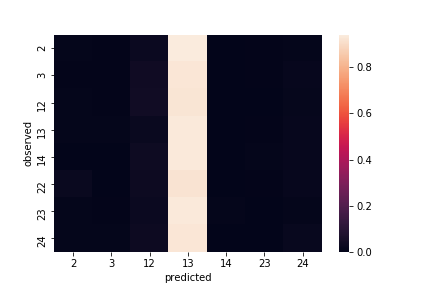

In [106]:
import seaborn as sns; sns.heatmap(validate.model_crosstab(m))